<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

<h2 align="center">Pushkarini Agharkar</h2> 
<h3 align="center"> Airline Dataset Analysis for Spotify Interview</h3> 

**Data Sources:**
1. Bureau of Transportation Statistics http://www.transtats.bts.gov/
2. National Oceanic and Atmospheric Administration http://www.noaa.gov/weather

**Analysis Questions:** 
1. What everyone has an opinion on - Which is the **better of the three airports** in/close to New York - **JFK, LGA, EWR**. I attempt to answer this scientifically by comparing the three airports with respect to range of destinations and carriers offered, airline delays and cancellations. 
2. Next, I study how a **storm hitting the midwest and east coast affects cancellations** in the rest of the country.

**Assumptions: **
1. The cancelled flights do not have planned departure time. So their intended departure time is assumed to be equal to departure time of the previous flight in the database. It is appreciated that this might be a big assumption for large blocks of cancellations due to storms etc.
2. It is assumed that the weather of JFK, EWR and LGA is more or less the same (as the weather recorded in JFK).

** Tasks and Accomplishments **
1. Cleaned the weather data obtained for NOAA website and merged it with BTS database.
2. Found that **LGA has 75% shorter delays** and **JFK has 50% fewer cancellations** compared to ohter airports in the trio. 
3. Showed that precipitation and air traffic together accounted for 75.2% of the variance in cancellations and **precipitation** alone accounted for **74.8% of the variance in cancellations**. 
4. Noticed that the homoskedasticity assumptions are violated by the residuals (homoskedasticity is necessary for the linear regression estimator to be BLUE), and their quantiles suggest possibility of non-normality (normality of residuals is necessary for it to be MLE). The linear regression model thus needs closer attention. 
5. Identified anomaly (large Alberta Clipper storm ) starting in the mid-west. 
6. Found that the storm that starts affecting the mid-west on morning of January 25th 2015, takes **one day to affect the east coast** (possibly also because it traveled in that direction) and **two days to affect California** (i.e. comparable impact in California happens on morning of January 27th 2015).

** Further Ideas ** 
1. A predictive model could be built to estimate delays with respect to weather conditions in all cities as well as overall airtraffic at that time. This can equip airlines with preventive measures to shorten delays and cancellations. 
2. Analysis of delays and cancellations over years can be conducted to get a sense of improvements (or lack thereof) in performance of the airline industry. 

** Note **
1. Code to clean weather data is not shared but the cleaned files are attached.
2. Basemap is used to visualize delays on the U.S Map. requirements: Basemap, NetCDFFile.
3. All data is zipped in the folder data. To run notebook, extract all data into the root/data folder. 


In [13]:
### loading the libraries 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML
from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile
from sklearn import linear_model
import scipy.stats as stats

** Comparitive Analysis of airports close to New York City ** 

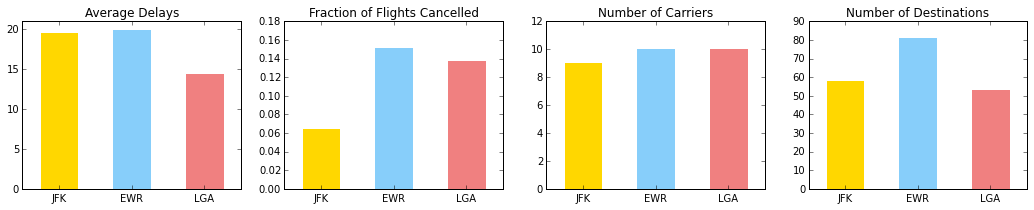

In [14]:
## comparison of the three airports 
comparison = pd.read_csv('data/Feb_14.csv')

jfk = comparison[comparison['ORIGIN']=='JFK']
ewr = comparison[comparison['ORIGIN']=='EWR']
lga = comparison[comparison['ORIGIN']=='LGA']
jfk_destinations = len(set(jfk['DEST'])); ewr_destinations = len(set(ewr['DEST'])); lga_destinations = len(set(lga['DEST']));
jfk_carriers = len(set(jfk['UNIQUE_CARRIER'])); ewr_carriers = len(set(ewr['UNIQUE_CARRIER'])); 
lga_carriers = len(set(lga['UNIQUE_CARRIER']));
jfk_delays = jfk['DEP_DELAY'].mean(); ewr_delays = ewr['DEP_DELAY'].mean(); lga_delays = lga['DEP_DELAY'].mean(); 
jfk_cancellations = jfk['CANCELLED'].mean(); ewr_cancellations = ewr['CANCELLED'].mean(); 
lga_cancellations = lga['CANCELLED'].mean(); 

destinations = [jfk_destinations, ewr_destinations, lga_destinations];
cancellations = [jfk_cancellations, ewr_cancellations, lga_cancellations];
delays = [jfk_delays, ewr_delays, lga_delays];
carriers = [jfk_carriers, ewr_carriers, lga_carriers];

## visualizing the differences
N = 3; x = range(N); width = 0.5;
plt.figure(figsize=(18,3))
plt.subplot(141);
barlist = plt.bar(x, delays, width); barlist[0].set_color('gold'); barlist[1].set_color('lightskyblue');
barlist[2].set_color('lightcoral'); plt.title('Average Delays'); plt.ylim([0,21]); plt.xlim([-0.25,2.75]);
plt.xticks([0.25,1.25,2.25], ['JFK','EWR','LGA']);

plt.subplot(142);
barlist = plt.bar(x, cancellations, width); barlist[0].set_color('gold'); barlist[1].set_color('lightskyblue');
barlist[2].set_color('lightcoral'); plt.title('Fraction of Flights Cancelled'); plt.ylim([0,.18]); plt.xlim([-0.25,2.75]);
plt.xticks([0.25,1.25,2.25], ['JFK','EWR','LGA']);

plt.subplot(143);
barlist = plt.bar(x, carriers, width); barlist[0].set_color('gold'); barlist[1].set_color('lightskyblue');
barlist[2].set_color('lightcoral'); plt.title('Number of Carriers'); plt.ylim([0,12]); plt.xlim([-0.25,2.75]);
plt.xticks([0.25,1.25,2.25], ['JFK','EWR','LGA']);

plt.subplot(144);
barlist = plt.bar(x, destinations, width); barlist[0].set_color('gold'); barlist[1].set_color('lightskyblue');
barlist[2].set_color('lightcoral'); plt.title('Number of Destinations'); plt.ylim([0,90]); plt.xlim([-0.25,2.75]);
plt.xticks([0.25,1.25,2.25], ['JFK','EWR','LGA']);

** Summary **
1. **LGA has 75% shorter delays** than JFK and EWR.
2. **JFK has 50% fewer (fraction of flights) cancellations** as EWR and LGA.
3. **EWR offers 33 % most destinations** compared to JFK and LGA. 

Note that these are only those airlines that operate domestic flights, since the data only contains those. 


** Visualizing the correlation between weather and cancellations in Laguardia airport **

Although not all of the cancellations are explained by the precipitation conditions, a large fraction is visually correlated with precipitation.

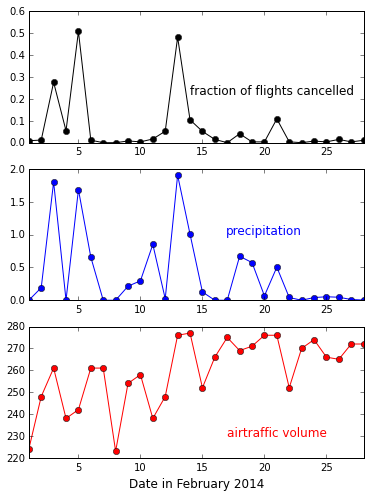

In [15]:
## seeing if there is any correlation between weather, air traffic and cancellations
airports = pd.read_excel('data/airports new.xlt')
onemonth_traffic = pd.read_csv('data/Feb_14.csv')
onemonth_weather = pd.read_csv('data/b1402.csv')

onemonth_traffic['DEP_TIME'].fillna(method='backfill',inplace=True)

flights_jfk = onemonth_traffic[onemonth_traffic['ORIGIN']=='JFK']
cancellations_jfk = flights_jfk.groupby('DAY_OF_MONTH').mean(); 
traffic_volume = flights_jfk.groupby('DAY_OF_MONTH').size(); cancellations = cancellations_jfk['CANCELLED']
delays = flights_jfk.groupby('DAY_OF_MONTH').mean(); delays = delays['DEP_DELAY']

onemonth_weather_daily_sum = onemonth_weather.groupby('wday').sum()[0:28] 
onemonth_weather_daily_mean = onemonth_weather.groupby('wday').sum()[0:28] 
hum = onemonth_weather_daily_mean['hum']; precip = onemonth_weather_daily_sum['precip'];
date = np.arange(1,29)

plt.figure(figsize=(6,8))
plt.subplot(311)
plt.plot(date,cancellations,'-ok');  
plt.text(14,.22,'fraction of flights cancelled', fontsize=12,color = 'k'); 
plt.xlim([1,28]);

plt.subplot(312)
plt.plot(date,precip,'-ob');
plt.text(17,1,'precipitation', fontsize=12,color = 'b'); 
plt.xlim([1,28]);

plt.subplot(313)
plt.plot(date,traffic_volume,'-or');
plt.text(17,230,'airtraffic volume', fontsize=12,color = 'r'); 
plt.xlabel('Date in February 2014',fontsize=12); plt.xlim([1,28]);

** Predictive Model for Estimating Cancellations **

A simple linear regression model is built to predict fraction of flights cancelled in JFK in Feb 2014. The features considered are airtraffic volume on that day as well as weather conditions (specifically precipitation).

R-squared error for model with precipitation and traffic volume as features is 0.752103641127
R-squared error for model with precipitation only is 0.747832868188


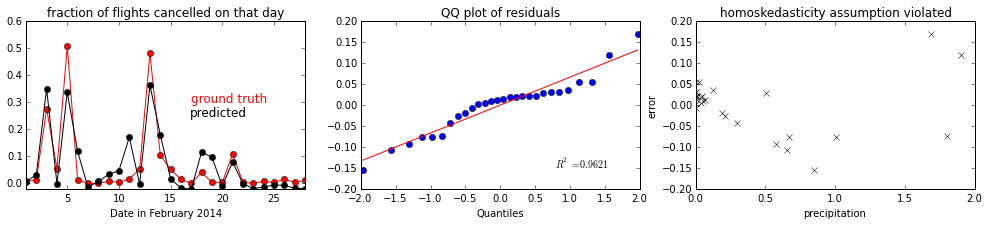

In [16]:
## linear regression to predict cancellations as a function of precipitation as well as air traffic data
x = np.vstack((np.asarray(precip),np.asarray(traffic_volume))); 
y = np.asarray(cancellations); x = np.transpose(x);
 
cancellations_predictor = linear_model.LinearRegression(fit_intercept=True,normalize=False,copy_X=True);
cancellations_predictor.fit(x,y)
print 'R-squared error for model with precipitation and traffic volume as features is', cancellations_predictor.score(x,y)
y_predict = cancellations_predictor.predict(x);
residue = y-y_predict;
plt.figure(figsize=(17,3));

plt.subplot(131); plt.plot(date,y,'-or'); plt.plot(date,y_predict,'-ok');
plt.title('fraction of flights cancelled on that day'); plt.xlabel('Date in February 2014');
plt.text(17,.25,'predicted', fontsize=12,color = 'k'); plt.text(17,.3,'ground truth', fontsize=12,color = 'r'); 
plt.ylim([-0.02,0.6]); plt.xlim([1,28]); 
plt.subplot(132);  
stats.probplot(residue, dist="norm", plot=plt); plt.title('QQ plot of residuals'); plt.ylabel('');

x1 = np.asarray(precip); x1 = np.reshape(x1,((28,1)));
cancellations_predictor_withprecip = linear_model.LinearRegression(fit_intercept=True,normalize=False,copy_X=True);
cancellations_predictor_withprecip.fit(x1,y);
print 'R-squared error for model with precipitation only is', cancellations_predictor_withprecip.score(x1,y);

plt.subplot(133); plt.plot(precip,residue,'xk'); plt.title('homoskedasticity assumption violated'); 
plt.xlabel('precipitation'); plt.ylabel('error');

 


** A bad day: 27 January 2015 sees extraordinary cancellations in JFK, EWR and LGA**

This was due to an Alberta Clipper storm which starts in Alberta, Canada, moves over  the great lakes, finally exiting through the Mid-Atlantic coast. Its development is shown here: 

The cancellations on that day and the surrounding days are compared for the three airports

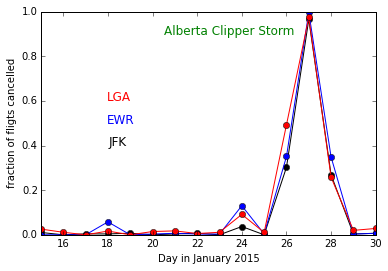

In [17]:
## looking at cancellations on days arounf the Alberta Clipper storm that hit midwest and east coast in Jan 2015
onemonth_traffic_badday = pd.read_csv('data/Jan_15.csv') 

cancellations_jfk = onemonth_traffic_badday[onemonth_traffic_badday['ORIGIN']=='JFK']
cancellations_jfk_serie = cancellations_jfk.groupby('DAY_OF_MONTH').mean(); 
cancellations_jfk_serie = cancellations_jfk_serie['CANCELLED']

cancellations_ewr = onemonth_traffic_badday[onemonth_traffic_badday['ORIGIN']=='EWR']
cancellations_ewr_serie = cancellations_ewr.groupby('DAY_OF_MONTH').mean(); 
cancellations_ewr_serie = cancellations_ewr_serie['CANCELLED']

cancellations_lga = onemonth_traffic_badday[onemonth_traffic_badday['ORIGIN']=='LGA']
cancellations_lga_serie = cancellations_lga.groupby('DAY_OF_MONTH').mean(); 
cancellations_lga_serie = cancellations_lga_serie['CANCELLED']
 
dates = np.arange(1,32)
plt.plot(dates,cancellations_jfk_serie,'-ok'); plt.plot(dates,cancellations_ewr_serie,'-ob'); 
plt.plot(dates,cancellations_lga_serie,'-or'); plt.xlim([15,30]);
plt.text(20.5,0.9,'Alberta Clipper Storm', fontsize=12,color = 'g');
plt.text(18,0.6,'LGA', fontsize=12,color = 'r');
plt.text(18,0.5,'EWR', fontsize=12,color = 'b');
plt.text(18,0.4,'JFK', fontsize=12,color = 'k');
plt.xlabel('Day in January 2015'); plt.ylabel('fraction of fligts cancelled');



** Spread of Delays and Cancellations to other parts of the country**

Now, we can visualize how the storm that starts in the midwest and travels east causes delays in the rest of the country. I start with collecting information about all delays and cancellations on 25, 26 and 27 January 2015

In [18]:
## converting departure times into hours of departure and then binning them into 8 hour blocks
def tryconvert(x,default):
    try:
        x = str(int(x))[:-2]
        try:
            return int(x)
        except:
            return default
    except:
        return 25
  
threedays_traffic = onemonth_traffic_badday[onemonth_traffic_badday['DAY_OF_MONTH'].isin([25,26,27])]
threedays_traffic.is_copy = False 
threedays_traffic['DEP_TIME'].fillna(method='backfill',inplace=True)
threedays_traffic['DEP_HOUR'] = threedays_traffic['DEP_TIME']
threedays_traffic['DEP_HOUR'] = threedays_traffic['DEP_HOUR'].apply(lambda x: tryconvert(x,0))
threedays_traffic['HOUR_BLOCKS'] = threedays_traffic['DEP_HOUR'].apply(lambda x: int(x/8))
threedays_traffic = threedays_traffic[['ORIGIN','DAY_OF_MONTH','DEP_TIME','DEP_HOUR','HOUR_BLOCKS','DEP_DELAY','CANCELLED']]
threedays_traffic.head(3)

,ORIGIN,DAY_OF_MONTH,DEP_TIME,DEP_HOUR,HOUR_BLOCKS,DEP_DELAY,CANCELLED
24,JFK,25,903,9,1,3,0
25,JFK,26,854,8,1,-6,0
26,JFK,27,856,8,1,NaN,1


In [19]:
# just checking that data manipulations are correct

jfk_flights_25th = len(threedays_traffic[(threedays_traffic['ORIGIN']=='JFK') & (threedays_traffic['DAY_OF_MONTH']==25)])
jfk_flights_26th = len(threedays_traffic[(threedays_traffic['ORIGIN']=='JFK') & (threedays_traffic['DAY_OF_MONTH']==26)])
jfk_flights_27th = len(threedays_traffic[(threedays_traffic['ORIGIN']=='JFK') & (threedays_traffic['DAY_OF_MONTH']==27)])

jfk_flights_25th_prev = len(cancellations_jfk[(cancellations_jfk['ORIGIN']=='JFK') & (cancellations_jfk['DAY_OF_MONTH']==25)])
jfk_flights_26th_prev = len(cancellations_jfk[(cancellations_jfk['ORIGIN']=='JFK') & (cancellations_jfk['DAY_OF_MONTH']==26)])
jfk_flights_27th_prev = len(cancellations_jfk[(cancellations_jfk['ORIGIN']=='JFK') & (cancellations_jfk['DAY_OF_MONTH']==27)])

print 'checking that the pandas dataframe manipulations are correct!'
print jfk_flights_25th, jfk_flights_26th, jfk_flights_27th
print jfk_flights_25th_prev, jfk_flights_26th_prev, jfk_flights_27th_prev

checking that the pandas dataframe manipulations are correct!
281 281 260
281 281 260


In [20]:
# visualizing delays in JFK 
all_delays = threedays_traffic.groupby(['ORIGIN','DAY_OF_MONTH','DEP_HOUR'],as_index=False).mean()
all_delays[(all_delays['ORIGIN']=='JFK') & (all_delays['DAY_OF_MONTH']==26)].head(6)

all_delays_blocks = threedays_traffic.groupby(['ORIGIN','DAY_OF_MONTH','HOUR_BLOCKS'],as_index=False).mean()
all_delays_blocks[(all_delays_blocks['ORIGIN']=='JFK') & (all_delays_blocks['DAY_OF_MONTH']==26)].head(3)

,ORIGIN,DAY_OF_MONTH,HOUR_BLOCKS,DEP_TIME,DEP_HOUR,DEP_DELAY,CANCELLED
1227,JFK,26,0,664.718750,6.328125,-0.023256,0.328125
1228,JFK,26,1,1131.492537,11.022388,24.704762,0.223881
1229,JFK,26,2,1871.710843,18.409639,68.591837,0.409639


In [21]:
# combining the grouped data with airport latitude and longitude data
airports_short = airports[['iata','lat','long']];
contours = pd.merge(all_delays_blocks, airports_short, how='outer', left_on='ORIGIN', right_on='iata',
      left_index=False, right_index=False, copy=False);

In [22]:
# creating separate datasets to plot cancellations for different days
morning_of_24th = contours[(contours['HOUR_BLOCKS']==0) & (contours['DAY_OF_MONTH']==24)]
afternoon_of_24th = contours[(contours['HOUR_BLOCKS']==1) & (contours['DAY_OF_MONTH']==24)]
evening_of_24th = contours[(contours['HOUR_BLOCKS']==2) & (contours['DAY_OF_MONTH']==24)]

morning_of_25th = contours[(contours['HOUR_BLOCKS']==0) & (contours['DAY_OF_MONTH']==25)]
afternoon_of_25th = contours[(contours['HOUR_BLOCKS']==1) & (contours['DAY_OF_MONTH']==25)]
evening_of_25th = contours[(contours['HOUR_BLOCKS']==2) & (contours['DAY_OF_MONTH']==25)]

morning_of_26th = contours[(contours['HOUR_BLOCKS']==0) & (contours['DAY_OF_MONTH']==26)]
afternoon_of_26th = contours[(contours['HOUR_BLOCKS']==1) & (contours['DAY_OF_MONTH']==26)]
evening_of_26th = contours[(contours['HOUR_BLOCKS']==2) & (contours['DAY_OF_MONTH']==26)]

morning_of_27th = contours[(contours['HOUR_BLOCKS']==0) & (contours['DAY_OF_MONTH']==27)]
afternoon_of_27th = contours[(contours['HOUR_BLOCKS']==1) & (contours['DAY_OF_MONTH']==27)]
evening_of_27th = contours[(contours['HOUR_BLOCKS']==2) & (contours['DAY_OF_MONTH']==27)]
 

In [23]:
# function to plot cancellations on a map
def plot_delays(x1m,x2m,x3m,x1a,x2a,x3a,x1e,x2e,x3e,themap,plot_title):
    nc = NetCDFFile('data/nws_precip_conus_20061222.nc')
    latcorners = nc.variables['lat'][:]
    loncorners = -nc.variables['lon'][:]
    lon_0 = -nc.variables['true_lon'].getValue()
    lat_0 = nc.variables['true_lat'].getValue()
    
    themap = Basemap(projection='gall',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],resolution='l',area_thresh=100000)
    themap.drawcoastlines(color='w'); themap.drawcountries(color='w'); themap.drawstates(color='azure')
    themap.fillcontinents(color = 'lavenderblush'); themap.drawmapboundary(fill_color='azure')
 
    x1m_new, x2m_new = themap(x2m, x1m)
    x1a_new, x2a_new = themap(x2a, x1a)
    x1e_new, x2e_new = themap(x2e, x1e)
    
    plt.suptitle(plot_title, fontsize=14)
    plt.subplots_adjust(top=1.1)
    
    plt.subplot(131); plt.title('morning')
    themap = Basemap(projection='gall',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],resolution='l',area_thresh=100000)
    themap.drawcoastlines(color='w'); themap.drawcountries(color='w'); themap.drawstates(color='w')
    themap.fillcontinents(color = 'lavenderblush'); themap.drawmapboundary(fill_color='azure')
    plt.scatter(x1m_new, x2m_new,s=200*x3m,zorder=2,facecolor='palevioletred')
    
    plt.subplot(132); plt.title('afternoon')
    themap = Basemap(projection='gall',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],resolution='l',area_thresh=100000)
    themap.drawcoastlines(color='w'); themap.drawcountries(color='w'); themap.drawstates(color='w')
    themap.fillcontinents(color = 'lavenderblush'); themap.drawmapboundary(fill_color='azure')
    plt.scatter(x1a_new, x2a_new,s=200*x3a,zorder=2,facecolor='palevioletred')
    
    plt.subplot(133); plt.title('evening')
    themap = Basemap(projection='gall',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],resolution='l',area_thresh=100000)
    themap.drawcoastlines(color='w'); themap.drawcountries(color='w'); themap.drawstates(color='w')
    themap.fillcontinents(color = 'lavenderblush'); themap.drawmapboundary(fill_color='azure')
    plt.scatter(x1e_new, x2e_new,s=200*x3e,zorder=2,facecolor='palevioletred')
    
    plt.show()

** Summary **

Following plots show Fraction of Flights cancelled at each airport during the storm. The size of the markers indicates the fraction. The storm starts near the greate lakes on 25th January morning. The resulting cacellations quickly spread to the midwest in one afternoon. By evening there are already few cancellations in San Francisco. By the next day, January 26th, there are cancellations all over the country and particularly on the east coast, as the storm spreads to the east coast as well. By the third day, January 27th, the cancellations in California are comparable to the initial cancellations in Chicago (where it all started) and by that night Chicago is already recovering and so is California. Cancellations on the east coast stil persist because of the greater impact the storm itself had on the east coast.  

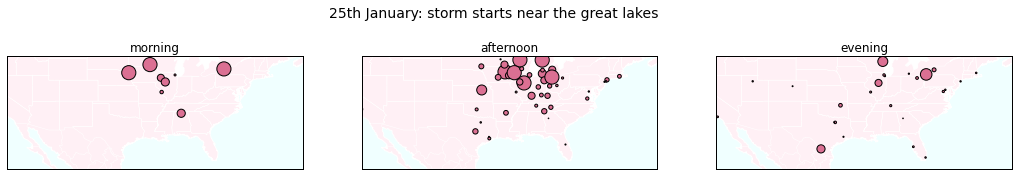

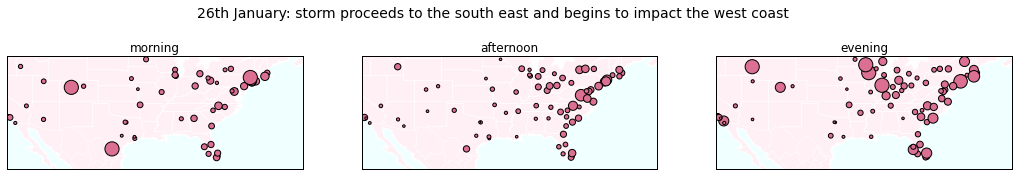

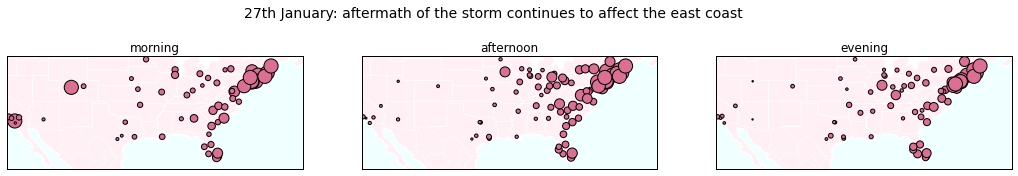

In [24]:

# converting dataframes into inputs for the plotting function
x1 = morning_of_25th['lat']; x2 = morning_of_25th['long']; x3 = morning_of_25th['CANCELLED'];  
x1m = np.asarray(x1); x2m = np.asarray(x2); x3m = np.asarray(x3); 
x1 = afternoon_of_25th['lat']; x2 = afternoon_of_25th['long']; x3 = afternoon_of_25th['CANCELLED'];  
x1a = np.asarray(x1); x2a = np.asarray(x2); x3a = np.asarray(x3); 
x1 = evening_of_25th['lat']; x2 = evening_of_25th['long']; x3 = evening_of_25th['CANCELLED'];  
x1e = np.asarray(x1); x2e = np.asarray(x2); x3e = np.asarray(x3); 
first_day = plt.figure(figsize=(18,4))
plot_delays(x1m,x2m,x3m,x1a,x2a,x3a,x1e,x2e,x3e,first_day,'25th January: storm starts near the great lakes')

x1 = morning_of_26th['lat']; x2 = morning_of_26th['long']; x3 = morning_of_26th['CANCELLED'];  
x1m = np.asarray(x1); x2m = np.asarray(x2); x3m = np.asarray(x3); 
x1 = afternoon_of_26th['lat']; x2 = afternoon_of_26th['long']; x3 = afternoon_of_26th['CANCELLED'];  
x1a = np.asarray(x1); x2a = np.asarray(x2); x3a = np.asarray(x3); 
x1 = evening_of_26th['lat']; x2 = evening_of_26th['long']; x3 = evening_of_26th['CANCELLED'];  
x1e = np.asarray(x1); x2e = np.asarray(x2); x3e = np.asarray(x3); 
second_day = plt.figure(figsize=(18,4))
plot_delays(x1m,x2m,x3m,x1a,x2a,x3a,x1e,x2e,x3e,second_day,'26th January: storm proceeds \
to the south east and begins to impact the west coast')

x1 = morning_of_27th['lat']; x2 = morning_of_27th['long']; x3 = morning_of_27th['CANCELLED'];  
x1m = np.asarray(x1); x2m = np.asarray(x2); x3m = np.asarray(x3); 
x1 = afternoon_of_27th['lat']; x2 = afternoon_of_27th['long']; x3 = afternoon_of_27th['CANCELLED'];  
x1a = np.asarray(x1); x2a = np.asarray(x2); x3a = np.asarray(x3); 
x1 = evening_of_27th['lat']; x2 = evening_of_27th['long']; x3 = evening_of_27th['CANCELLED'];  
x1e = np.asarray(x1); x2e = np.asarray(x2); x3e = np.asarray(x3); 
third_day = plt.figure(figsize=(18,4))
plot_delays(x1m,x2m,x3m,x1a,x2a,x3a,x1e,x2e,x3e,third_day,'27th January: aftermath of the storm continues \
to affect the east coast')
 